# Time Clustering algoritme voor Visual Attention Data

We proberen het model van Mulligan te reproduceren om (i) zijn methode te begrijpen, (ii) zien hoe we onze eigen technieken kunnen integreren.

### 1 Data genereren

Een sample van 1600 datapunten (elke 0.25s gedurende 400s) met elk punt een stochastische (sum = 1) 4-vector. Elke vector gesampled volgens leave one out in de eerste 4 x 40s en volgens leave 2 out in de laatste 6 x 40s

In [1]:
import numpy as np
from itertools import combinations as comb
meters = np.arange(4)

tasks =[]
for t in comb(meters,3):
    tasks += [t]
for t in comb(meters,2):
    tasks += [t]

def time2task(t):
    return t // 160

data = np.array([[np.random.rand() if i in tasks[time2task(t)] else 0 for i in range(4) ] for t in range(1600) ])
data += np.random.rand(1600,4)/1000 # add noise
data /= np.sum(data,axis=-1,keepdims=True) #normalise

### 2 Plot met vierkanten

Plotten gewoon het tensorproduct timeseries $\otimes$ timeseries, gesommeerd over alle onderliggende data (hier 4 componenten).

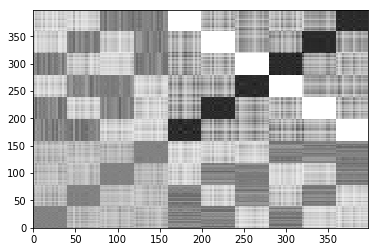

In [2]:
fullres = np.sum(np.expand_dims(data,0)*np.expand_dims(data,1),axis=-1)
clustered = np.sum(fullres.reshape((160,10,160,10)),axis=(1,-1))
z = clustered / np.amax(clustered)

import matplotlib.pyplot as plt

x, y = np.meshgrid(np.arange(160)/4*10,np.arange(160)/4*10)
plt.pcolormesh(x,y,z,cmap=plt.cm.Greys)
plt.show()

### 3 Clusteren van data in taken

Dit is Mulligan zijn werk, niet duidelijk hoe hij het gedaan heeft. We kunnen de clustering in eerste instantie doen aan de hand van de duidelijke zwarte vierkantjes, maar ook een standaard clusteringalgoritme kan werken. (Maar dat in de volgende sectie niet helemaal)

Hier zou weten hoe Mulligan dat juist gedaan heeft en hou hij de $\chi^2$test gebruikt daarvoor wel cool zijn. Dat zou dan tot zijn 16 clusters moeten leiden.... 


In [3]:
clusterindices1 = np.arange(len(data)).reshape((-1,160)) #cluster on sight

time_sensitivity=1 #large (~1) means adjacency in time is very important, 0 means irrelevant
data_spacetime = np.concatenate((data,np.expand_dims(np.arange(len(data))*time_sensitivity,axis=-1)),axis=-1)

from sklearn.cluster import AgglomerativeClustering 

clustering = AgglomerativeClustering(linkage='average', n_clusters=10)
clustering.fit(data_spacetime)

def collect(a):
    out = []
    ind=np.arange(len(a))
    for val in np.unique(a):
        out += [ind[a==val]]
    return out

#sort labels in order of appearence
relabeled=np.copy(clustering.labels_)
u,ind = np.unique(relabeled,return_index=True)
for i,l in zip(np.arange(len(u)),u[np.argsort(ind)]):
    relabeled[clustering.labels_==l]=i

clusterindices2=collect( relabeled)


### 4 Distributie

We kunnen in eerste instantie de distributie halen uit het gemiddelde van states. (Als we later de Markov matrix zelf bepalen zouden dat de stabiele toestanden ervan moeten zijn, bij minder data is dat de betere methode)

We kunnen de clustering eens plotten voor de exacte opdeling die we op het zicht uit de vierkantjes gehaald hebben, en eens die met een willekeurig gekozen clustering algoritme. Dat eerste is natuurlijk heel accuraat, het laatste not so much. Dat toont toch aan dat Mulligan zijn werk niet zo evident is.

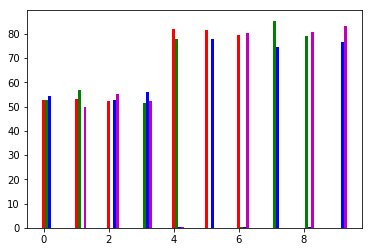

In [4]:
taskwise = [np.sum(data[lst],axis=0) for lst in clusterindices1] 

fig,ax = plt.subplots()
nr=len(taskwise)
col = ['r','g','b','m']
for c,x in zip(taskwise,range(nr)):
    for i in range(4):
        ax.bar(x+i/(nr+1),height=c[i],width = 1.0/(nr+1),color = col[i])
plt.show()

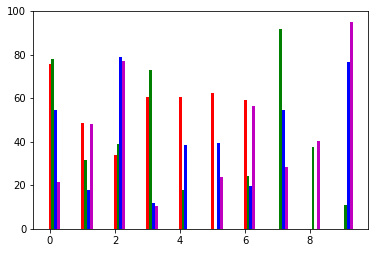

In [5]:
taskwise = [np.sum(data[lst],axis=0) for lst in clusterindices2] 

fig,ax = plt.subplots()
nr=len(taskwise)
col = ['r','g','b','m']
for c,x in zip(taskwise,range(nr)):
    for i in range(4):
        ax.bar(x+i/(nr+1),height=c[i],width = 1.0/(nr+1),color = col[i])
plt.show()

We zien dat zo'n clustering de 6 leave 2 out's wel vindt, maar daar te veel data heeft ingestoken, zodat er leave 3 ipv 1 out clusters overblijven... 

Dat kunnen we ook checken als de exacte en berekekende clusterlengtes naast elkaar zetten:

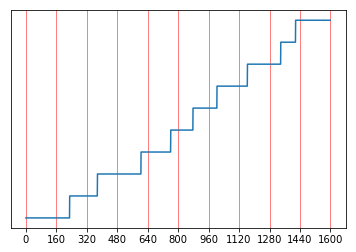

In [6]:
fig,ax = plt.subplots()
ax.plot(relabeled)
ax.grid(color='r', linestyle='-', linewidth=0.5)
ax.set_xticks(np.arange(11)*160)
ax.set_yticks([])
plt.show()